In [1]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it to at least version 3."

import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set fixed random seed for reproducibility
np.random.seed(2022)

This class contains all the functions needed to generate the dataset. Instructions below.

Unfortunately it takes a long time so I will run it overnight. You can easily generate a sample dataset with a low number of samples per class, for example: su.make_dataset(treee, num_samples_per_class = 5).

I imagine for actual training we may need anything between 100 and 1000 samples per class.

In [2]:
class Synthetic_Dataset_Utils():

    def __init__(self, kernel_type = "RBF"):

        if(kernel_type == "RBF"):
          self.kernel = self.RBF_kernel

    def get_distance(self, x1,x2):

        return np.sqrt(np.sum((x1-x2)**2))

    def RBF_kernel(self, x1, x2, theta):
        """
        Define the multivariate kernel function.

        Parameters
        ----------
        x1 : (D,) np.ndarray
          A D-dimensional data point.
        x2 : (D,) np.ndarray
          Another D-dimensional data point.
        theta : (4,) np.ndarray
          The array containing the hyperparameters governing the kernel function.

        Returns
        -------
        float
          Value of the kernel function.
        """

        x1 = np.array([x1])
        x2 = np.array([x2])


        return theta[0] * np.exp(- theta[1]/2 * self.get_distance(x1, x2)**2 ) + theta[2] + theta[3] * x2@x1.reshape(-1,1)


    def compute_Gram_matrix(self, X, theta):
        N = X.shape[0]
        X_norm = np.sum(X**2, axis=1).reshape(-1,1)
        distance_squared = X_norm + X_norm.T - 2 * X @ X.T
        G = theta[0] * np.exp(- theta[1]/2 * distance_squared) + theta[2] + theta[3] * X @ X.T
        regularizer = np.eye(N)*1.e-8
        return G + regularizer

    def compute_Gram_matrix_GPU(self, X, theta):
        import torch
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        X_torch = torch.from_numpy(X).to(device)
        theta_torch = torch.from_numpy(theta).to(device)
        N = X_torch.shape[0]
        X_norm = torch.sum(X_torch**2, dim=1).view(-1,1)
        distance_squared = X_norm + X_norm.T - 2 * X_torch @ X_torch.T
        K_torch = theta_torch[0] * torch.exp(- theta_torch[1]/2 * distance_squared) + theta_torch[2] + theta_torch[3] * X_torch @ X_torch.T
        regularizer = torch.eye(N, device=device)*1.e-8
        return K_torch + regularizer


    def generate_surfaces(self, theta, num_samples = 1, N = 21):

        x = np.linspace(-1, 1, N)
        y = np.linspace(-1, 1, N)
        X, Y = np.array(np.meshgrid(x, y))
        X = np.stack([X.ravel(), Y.ravel()], axis=1)
        S = X.shape[0]
        mu = np.zeros(S)
        K = self.compute_Gram_matrix(X, theta)
        curves = np.random.multivariate_normal(mu, K, size = num_samples)
        return [curve.reshape((N,N)) for curve in curves]

    def generate_surfaces_GPU(self, theta, num_samples=1,  N = 21):

        x = np.linspace(-1, 1, N)
        y = np.linspace(-1, 1, N)
        X, Y = np.array(np.meshgrid(x, y))
        X = np.stack([X.ravel(), Y.ravel()], axis=1)
        S = X.shape[0]
        mu = np.zeros(S)
        import torch
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        mu_torch = torch.from_numpy(mu).to(device)
        K_torch = self.compute_Gram_matrix_GPU(X, theta)
        mvn = torch.distributions.MultivariateNormal(mu_torch, covariance_matrix=K_torch)
        curves_torch = mvn.sample((num_samples,))
        curves = curves_torch.cpu().numpy()
        return [curve.reshape((N,N)) for curve in curves]


    def plot_curve(self, curve, title = "Curve"):

        curve = curve[0]

        N = curve.shape[1]
        x = np.linspace(-1, 1, N)
        y = np.linspace(-1, 1, N)

        X, Y = np.array(np.meshgrid(x, y))


        ax = plt.figure().add_subplot(projection='3d')

        surf = ax.plot_surface(X, Y, curve, cmap='viridis')

        plt.title(title)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()




    def build_tree(self, params, depth, max_depth, num_classes_per_level, std_multiplier, ranges):
      node = [params]  # The first element is the parameters at this node

      if depth >= max_depth:
          return node  # Return the node containing only parameters

      else:
          children = []

          for _ in range(num_classes_per_level):

              new_params = []
              for p_idx, parameter in enumerate(params):

                  std_dev = std_multiplier * ranges[p_idx] / ((num_classes_per_level) ** (depth + 1))
                  sampled_param = np.random.normal(loc=parameter, scale=std_dev)
                  while(sampled_param < 0):
                      sampled_param = np.random.normal(loc=parameter, scale=std_dev)
                  new_params.append(sampled_param)

              # Recursively build the child node
              child_node = self.build_tree(new_params, depth + 1, max_depth, num_classes_per_level, std_multiplier, ranges)
              children.append(child_node)

          node.append(children)  # Append the list of children to the node
          return node

    def get_parameters_by_index(self, tree, indices):
      node = tree
      if not isinstance(indices, tuple):
          indices = (indices,)
      for idx in indices:
          # Parameters are at node[0], children are at node[1]
          if len(node) <= 1:
              raise IndexError("No further children at this index")
          node = node[1][idx]  # Move to the child node at the given index
      return node[0]  # Return the parameters at the final node


    def get_parameters_by_depth(self, tree, depth):
      result = []
      if depth == 0:
          return [tree[0]]
      elif len(tree) > 1:
          for child in tree[1]:
              result.extend(self.get_parameters_by_depth(child, depth - 1))
      return result


    def _get_cat_idx(self, num_classes_per_level, max_depth):
      cat_idx = []

      for i in range(27):

        idx = []

        for j in reversed(range(max_depth)):

          z = math.floor(i/num_classes_per_level**j)
          idx.append( z % num_classes_per_level)

        cat_idx.append(tuple(idx))

      return tuple(cat_idx)

    def get_depth(self, tree):

        if len(tree) <= 1:  # No children, depth is 1
            return 0
        else:
            # Add 1 for the current level and calculate the max depth of the children
            return 1 + max(self.get_depth(child) for child in tree[1])

    def make_dataset(self, tree, num_samples_per_class, GPU = True, N=21):
        min_ = None,
        max_ = None 

        dataset = {}
        max_depth = self.get_depth(tree)
        num_classes_per_level = len(self.get_parameters_by_depth(tree, 1))

        leaves = self.get_parameters_by_depth(tree, max_depth)   # Actual final categories

        categories = {}
        curves = {}

        category_indexes = self._get_cat_idx(num_classes_per_level, max_depth)

        for i, leaf in enumerate(leaves):

          categories[category_indexes[i]] = tuple(leaf)


        for i, leaf in enumerate(leaves):

          if GPU:
            curves[category_indexes[i]] = [curve.reshape(N,N) for curve in self.generate_surfaces(leaf, num_samples = num_samples_per_class, N = N)]
          else:
            curves[category_indexes[i]] = [curve.reshape(N,N) for curve in self.generate_surfaces(leaf, num_samples = num_samples_per_class, N = N)]

          

        dataset["categories"] = categories
        dataset["curves"] = curves

        return dataset

    def get_curves(self, dataset, category):

        return dataset["categories"][category], dataset["curves"][category]






Make class instance

In [3]:
su = Synthetic_Dataset_Utils()

Example of surface generation (each surface is parametrized by 4 numbers)

In [4]:
surf = su.generate_surfaces((1,40,1,11), N = 30)

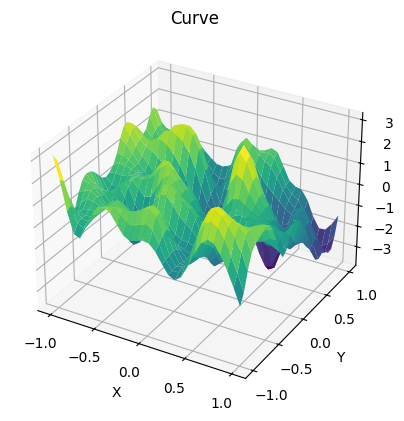

In [5]:
su.plot_curve(surf)

In [6]:
surf[0].shape

(30, 30)

Here we generate a tee: it contains generated parameters for curves, generated in a hierarchical way. To explore a tree, we can use su.get_parameters and su.get_parameters_by_depth. Each depth corresponds to one level of the hierarchy.

At depth 0, there are the prior_params (seed params).

At depth 1, there will be all the params generated from the prior params. Their number is equal to num_classes_per_level.

At depth 2, there will be all the params generated from the params of depth 1. Thus, in total they will be num_classes_per_level^2.

Ecc ecc



Ranges define the supposed range each of the 4 parameters can fall on. I am not sure about the best values for ranges.

For training I would suggest 3<num_classes_per_level<8.

std_multiplier regulates how muct standard deviation the parameter generator function has, meaning at each depth how much std we can expect from the previous param. If in a certain range there are as many "boxes" (subranges) as many classes we have for that parameter, std_multiplier = 1 would mean the std is equal to one box.

I would suggest not setting it higher than 1, because it would mean different classes could end up having some parameters very close to each other. It could still work but better to avoid it.


In [308]:


ranges = [20,20,20,20]  # Ranges for each parameter

prior_params = [10,10,10,10]  # Initial parameters

# Build the tree
max_depth = 3 # Adjust as needed
num_classes_per_level = 3  # Adjust as needed

std_multiplier = 1

treee = su.build_tree(prior_params, 0, max_depth, num_classes_per_level, std_multiplier, ranges)

In [309]:
su.get_depth(treee)

3

In [310]:
su.get_parameters_by_depth(treee, 0)

[[10, 10, 10, 10]]

In [311]:
su.get_parameters_by_depth(treee, 1)

[[8.078626812986096, 5.934515090136237, 5.552744524631274, 20.394798589618105],
 [20.0155976449808, 10.595061119842894, 7.737517613356126, 11.439493945283857],
 [9.379331978531669, 18.201190423787175, 9.902473967048785, 6.152810887002175]]

In [316]:
# This one is a bit confusing but we do not really need it since we may mainly interact with the synth dataset which has a nice getter function.
# This starts from depth 1 instead than 0

for n in range(3):
  print(su.get_parameters_by_index(treee, (n)))

[8.078626812986096, 5.934515090136237, 5.552744524631274, 20.394798589618105]
[20.0155976449808, 10.595061119842894, 7.737517613356126, 11.439493945283857]
[9.379331978531669, 18.201190423787175, 9.902473967048785, 6.152810887002175]


Let's make a small dataset, and explore the generated curves. I'm trying to find the best parameters to make clearly distinguishable curves.

IMPORTANT: N determines the size of the curves. It takes much longer for larger sizes so now we use a small one.

In [321]:
synth_dataset = su.make_dataset(treee, num_samples_per_class=5, N=18)

Now, let's explore the dataset with the getter function. We get the 5 samples of curves of category 111 (which is 1 grandchild of 1 and a child of 11). The getter function returns the parameters associated with category 111 and the 5 sample curves

In [322]:
params, curves = su.get_curves(synth_dataset, (1,1,1))

In [323]:
params

(19.597198838759084, 8.950349143486733, 9.077573368385147, 6.622184389655766)

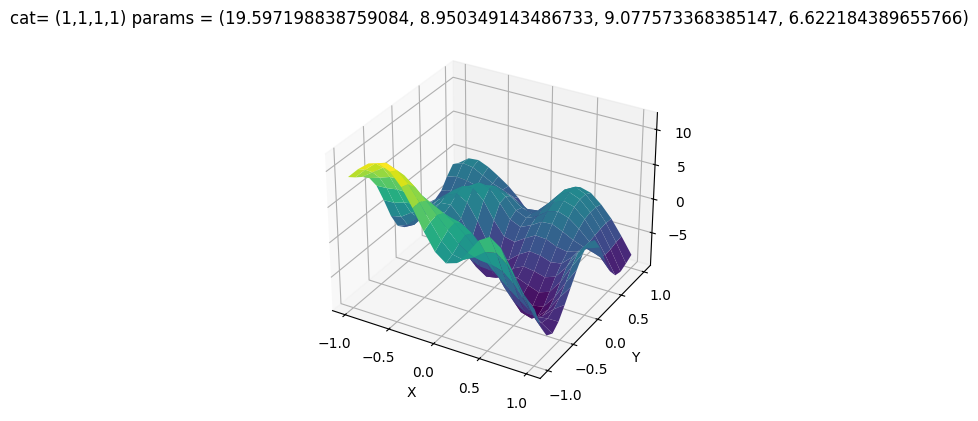

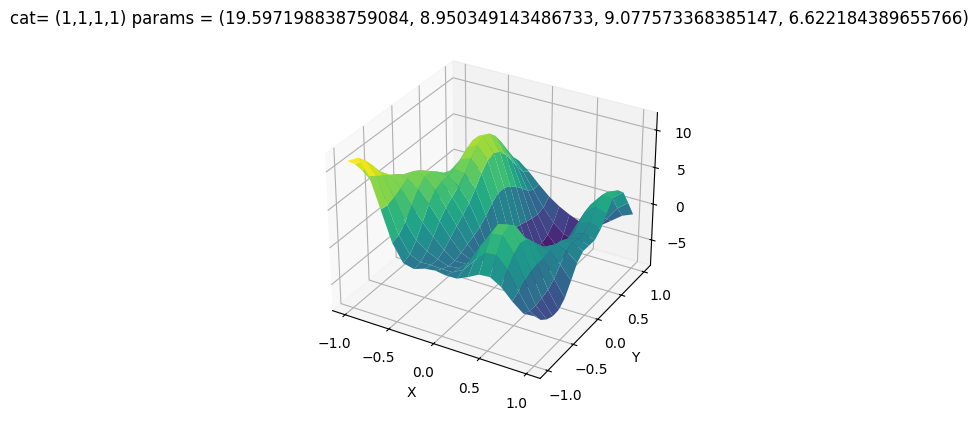

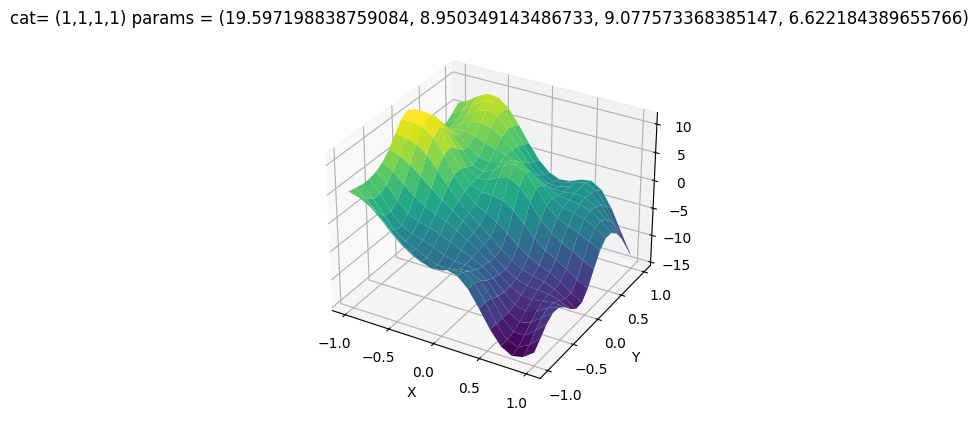

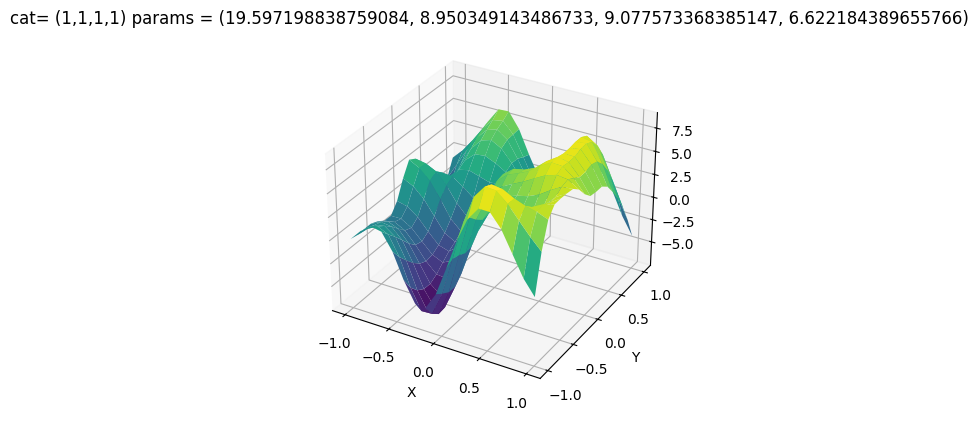

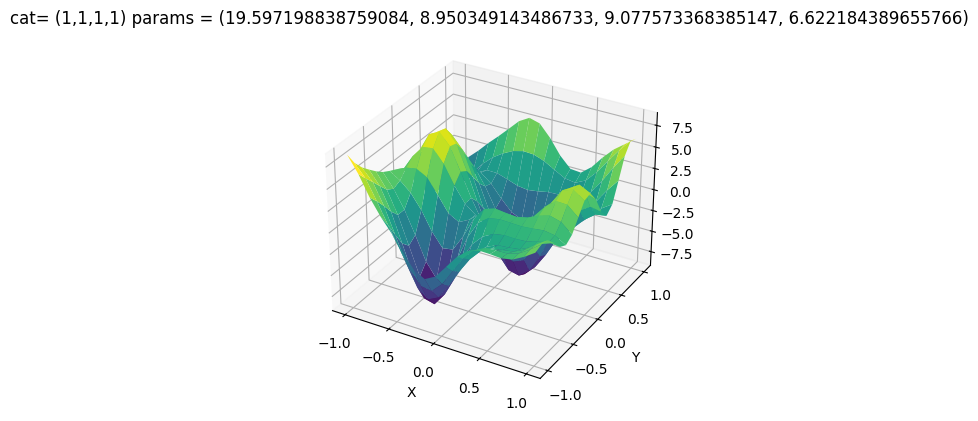

In [324]:
for curve in curves:
    su.plot_curve([curve], title = "cat= (1,1,1,1) "+ "params = "+ str(params))